# Wareham River Raw Data Parsing
On July 12 the JetYak was used at a site in the Wareham River in which processed wastewater was being pumped. The extremely tidal nature of the river, in addition to the methane rich effluent, makes the site particularly interesting to a number of scientists.

This notebook is an attempt to explore the data collected from the JetYak and identify preliminary patterns. Further processing of the data will be done in a future notebook.

In [41]:
import pandas as pd
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib
% matplotlib inline
import seaborn as sns
from IPython.display import display
import sensor_cleaning as sc
from scipy.interpolate import interp1d

CTD_filename = './CTD/data.txt'
GGA_filename= './GGA/gga_2017-07-12_f0001.txt'
Op1_filename='./Optode/optode_20170712144117.txt'
Op2_filename='./Optode/optode_20170712155518.txt'
Op3_filename='./Optode/optode_20170712194058.txt'
AirMar1_filename='./Weather_Station/airmar1.txt'
AirMar2_filename='./Weather_Station/airmar2.txt'
AirMar3_filename='./Weather_Station/airmar4.txt'
DGE_filename= './DGE/dge_170712_wareham_jetyak_deployment.dat'
Nitrate1_filename = './Nitrate/A0066322.CSV'
Nitrate2_filename= './Nitrate/A0066323.CSV'
Nitrate3_filename= './Nitrate/A0066324.CSV'

pd.set_option('display.max_columns', None)

# more info at http://matplotlib.org/users/customizing.html
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

In [42]:
reload(sc)

<module 'sensor_cleaning' from 'sensor_cleaning.py'>

In [43]:
ctd = pd.read_table(CTD_filename, delimiter=',', header=0)
ctd.head(2)

,Time,Conductivity,Temperature,Pressure,Sea pressure,Depth,Salinity,Specific conductivity,Density anomaly,Speed of sound
0,2017-07-12 13:37:06.000,0.001021,26.299316,10.051146,-0.081354,-0.080691,0.012289,0.996425,NaN,1500.126763
1,2017-07-12 13:37:06.167,0.000330,26.325406,10.049328,-0.083172,-0.082494,0.012392,0.321977,NaN,1500.194016


In [44]:
gga = pd.read_table(GGA_filename, delimiter=', ', header=1, engine='python')
gga.head(2)

,Time,[CH4]_ppm,[CH4]_ppm_sd,[CH4L]_ppm,[CH4L]_ppm_sd,[CH4H]_ppm,[CH4H]_ppm_sd,[H2O]_ppm,[H2O]_ppm_sd,[CO2]_ppm,[CO2]_ppm_sd,[CH4]d_ppm,[CH4]d_ppm_sd,[CO2]d_ppm,[CO2]d_ppm_sd,GasP_torr,GasP_torr_sd,GasT_C,GasT_C_sd,AmbT_C,AmbT_C_sd,RD0_us,RD0_us_sd,RD1_us,RD1_us_sd,Fit_Flag,MIU_VALVE,MIU_DESC
0,07/12/2017 13:51:38.726,1.90953,0.0,1.90953,0.0,-0.01,0.0,26943.3,0.0,391.372,0.0,1.9624,0.0,402.208,0.0,140.351,0.0,26.6326,0.0,31.4830,0.0,9.80065,0.0,12.4203,0.0,3.0,0.0,1 meters
1,07/12/2017 13:51:39.703,1.90693,0.0,1.90693,0.0,-0.01,0.0,26975.3,0.0,391.286,0.0,1.9598,0.0,402.134,0.0,140.396,0.0,26.6337,0.0,31.4815,0.0,9.79726,0.0,12.4171,0.0,3.0,0.0,1 meters


In [45]:
op = pd.read_table(Op1_filename, delimiter=',', header=0, engine='python')
temp_op1 = pd.read_table(Op2_filename, delimiter=',', header=0, engine='python')
temp_op2 = pd.read_table(Op3_filename, delimiter=',', header=0, engine='python')

op = op.append(temp_op1, ignore_index=True)
op = op.append(temp_op2, ignore_index=True)

print len(op)
op.head(2)

3470


,posixtime,model,SN,O2Concentration,AirSaturation,Temperature,CalPhase,TCPhase,C1RPh,C2RPh,C1Amp,C2Amp,RawTemp
0,1.499870e+09,4831,277,189.8738,74.14807,25.39276,33.18269,33.18269,41.85463,8.671936,653.6945,718.0435,29.84055
1,1.499870e+09,4831,277,189.7653,74.11290,25.39804,33.18711,33.18711,41.86147,8.674355,653.6395,717.8172,29.66982


In [46]:
airmar = pd.read_table(AirMar1_filename, delimiter=',', header=0)

temp = pd.read_table(AirMar2_filename, delimiter=',', header=0)
temp2 = pd.read_table(AirMar3_filename, delimiter=',', header=0)

airmar = airmar.append(temp, ignore_index=True)
airmar = airmar.append(temp2, ignore_index=True)

airmar.head(2)

,lat,lon,alt_M,geo_sep_M,COG_T,SOG_K,TOD,day,month,year,pressure_B,air_temp_C,wind_dir_T,wind_speed_M,reference,rateofturn,rel_wind_chill_C,theo_wind_chill_C,else
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,*48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
dge = pd.read_table(DGE_filename, delimiter=',', header=1)
dge.head(2)

/home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,TIMESTAMP,RECORD,AO_ch1_Avg,AO_ch2_Avg,AO_ch3_Avg,AO_ch4_Avg,MFC_GasInlet_Avg,MFM_GasOutlet_Avg,LFM_LiquidFlow_Avg,WFM_WasteGas_Avg,Liquid_Press_Avg,Liquid_Temp_Avg,SweepGas_Press_Avg,NotUsed_Avg,SEVolt_ch13_Avg,SEVolt_ch14_Avg,SEVolt_ch15_Avg,SEVolt_ch16_Avg
0,TS,RN,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV,mV
1,NaN,NaN,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg,Avg


In [48]:
nitrate = pd.read_table(Nitrate1_filename, delimiter=',', header=14)
temp1 = pd.read_table(Nitrate2_filename, delimiter=',', header=14)
temp2 = pd.read_table(Nitrate3_filename, delimiter=',', header=14)

nitrate = nitrate.append(temp1, ignore_index=True)
nitrate = nitrate.append(temp2, ignore_index=True)

nitrate.head(2)

,SATSDF0342,2017192,20.364744,0.00,0.0000,0.0000.1,0.0000.2,0.00.1,661,0,1,644,631,645,641,641.1,644.1,642,647,633,647.1,647.2,637,636,653,640,645.1,642.1,645.2,640.1,641.2,641.3,640.2,663,652,659,663.1,674,662,669,665,671,673,667,678,669.1,670,682,666,682.1,674.1,669.2,677,666.1,680,660,675,661.1,655,661.2,661.3,657,656,659.1,670.1,653.1,666.2,658,679,665.1,673.1,658.1,679.1,678.1,683,680.1,676,673.2,673.3,669.3,670.2,666.3,652.1,660.1,661.4,668,677.1,669.4,676.1,690,673.4,649,667.1,662.1,658.2,663.2,651,659.2,656.1,653.2,663.3,671.1,669.5,675.1,678.2,661.5,661.6,654,665.2,677.2,665.3,660.2,667.2,687,674.2,667.3,665.4,666.4,660.3,654.1,663.4,662.2,667.4,665.5,665.6,645.3,647.3,665.7,674.3,665.8,662.3,663.5,658.3,665.9,658.4,667.5,664,663.6,669.6,670.3,662.4,672,662.5,651.1,648,657.1,665.10,661.7,657.2,651.2,663.7,660.4,649.1,663.8,658.5,663.9,657.3,663.10,645.4,659.3,669.7,656.2,659.4,660.5,651.3,662.6,654.2,661.8,664.1,658.6,658.7,653.3,664.2,658.8,665.11,657.4,666.5,660.6,662.7,668.1,665.12,668.2,661.9,665.13,673.5,658.9,677.3,668.3,662.8,670.4,661.10,658.10,664.3,653.4,651.4,656.3,651.5,662.9,673.6,663.11,663.12,663.13,663.14,660.7,663.15,672.1,661.11,661.12,679.2,672.2,658.11,653.5,655.1,649.2,668.4,656.4,661.13,658.12,660.8,659.5,663.16,658.13,662.10,675.2,669.8,664.4,658.14,667.6,669.9,649.3,659.6,642.2,645.5,648.1,665.14,662.11,661.14,664.5,673.7,665.15,657.5,655.2,662.12,659.7,645.6,659.8,667.7,654.3,671.2,661.15,674.4,658.15,663.17,668.5,669.10,663.18,672.3,641.4,651.6,659.9,653.6,652.2,661.16,654.4,679.3,664.6,513,0.0,0.0.1,0.0.2,648300,32.5,12.1,0.1,5.0,44,0.00.2,0.00.3,0.0000.3,0.000000,0.000000.1,Unnamed: 281,Unnamed: 282,Unnamed: 283,Unnamed: 284,196
0,SATSDF0342,2017192,20.364744,0.00,0.0000,0.0000,0.0000,0.0,661,0,1,644,631,645,641,641,644,642,647,633,647,647,637,636,653,640,645,642,645,640,641,641,640,663,652,659,663,674,662,669,665,671,673,667,678,669,670,682,666,682,674,669,677,666,680,660,675,661,655,661,661,657,656,659,670,653,666,658,679,665,673,658,679,678,683,680,676,673,673,669,670,666,652,660,661,668,677,669,676,690,673,649,667,662,658,663,651,659,656,653,663,671,669,675,678,661,661,654,665,677,665,660,667,687,674,667,665,666,660,654,663,662,667,665,665,645,647,665,674,665,662,663,658,665,658,667,664,663,669,670,662,672,662,651,648,657,665,661,657,651,663,660,649,663,658,663,657,663,645,659,669,656,659,660,651,662,654,661,664,658,658,653,664,658,665,657,666,660,662,668,665,668,661,665,673,658,677,668,662,670,661,658,664,653,651,656,651,662,673,663,663,663,663,660,663,672,661,661,679,672,658,653,655,649,668,656,661,658,660,659,663,658,662,675,669,664,658,667,669,649,659,642,645,648,665,662,661,664,673,665,657,655,662,659,645,659,667,654,671,661,674,658,663,668,669,663,672,641,651,659,653,652,661,654,679,664,513,0.0,0.0,0.0,648300,32.5,12.1,0.1,5.0,44,0.00,0.00,0.0000,0.000000,0.000000,NaN,NaN,NaN,NaN,196
1,SATSLF0342,2017192,20.367355,11.62,0.1627,0.3185,0.3323,0.0,8892,661,1,642,660,650,661,652,655,658,660,659,661,656,654,666,700,796,1028,1469,2192,3174,4287,5406,6498,7506,8484,9393,10189,10855,11343,11599,11646,11474,11182,10809,10449,10140,9912,9787,9776,9890,10114,10464,10937,11544,12281,13118,14040,15004,15989,16921,17726,18365,18757,18872,18723,18323,17743,17059,16303,15568,14863,14232,13697,13233,12863,12594,12386,12292,12260,12298,12438,12632,12914,13256,13670,14131,14595,15062,15491,15861,16121,16228,16186,15961,15589,15079,14436,13750,13015,12274,11573,10923,10326,9788,9314,8915,8570,8293,8070,7898,7778,7677,7672,7687,7767,7864,8014,8197,8418,8691,8989,9306,9673,10017,10371,10710,11021,11286,11493,11634,11706,11687,11602,11450,11259,11007,10743,10481,10202,9933,9689,9467,9244,9068,8883,8754,8631,8516,8428,8367,8304,8281,8264,8251,8264,8297,8348,8409,8478,8558,8662,8781,8908,9061,9204,9368,9551,9707,9898,10092,10257,10440,10608,10779,10921,11056,11177,11276,11342,11360,11346,11274,11178,11027,10832,10628,10405,10169,9912,9662,9415,9169,8928,8687,8465,8254,8027,7814,7601,7398,7196,7014,6819,66

Great, all the data is now read in. Now we can work on cleaning and combining the data frames in an intelligent ways. The first thing will be to isolate the data from the actual trial period and trim the frames based upon that.

## CTD Cleaning
Let's start with a familiar sensor.

In [49]:
ctd = sc.clean_ctd(ctd)
ctd.head()

,Time,Conductivity,Temperature,Pressure,Sea pressure,Depth,Salinity,Specific conductivity,Density anomaly,Speed of sound,Year,Month,Day,Hour,Minute,Second,Julian_Date,Seconds_Elapsed
0,2017-07-12 13:37:06.000,0.001021,26.299316,10.051146,-0.081354,-0.080691,0.012289,0.996425,NaN,1500.126763,2017,7,12,13.0,37.0,6.000,2.457947e+06,1085826.000
1,2017-07-12 13:37:06.167,0.000330,26.325406,10.049328,-0.083172,-0.082494,0.012392,0.321977,NaN,1500.194016,2017,7,12,13.0,37.0,6.167,2.457947e+06,1085826.167
2,2017-07-12 13:37:06.333,0.001560,26.342928,10.062593,-0.069907,-0.069337,0.012328,1.521000,NaN,1500.239249,2017,7,12,13.0,37.0,6.333,2.457947e+06,1085826.333
3,2017-07-12 13:37:06.500,0.000821,26.358038,10.048503,-0.083997,-0.083312,0.012316,0.799721,NaN,1500.277856,2017,7,12,13.0,37.0,6.500,2.457947e+06,1085826.500
4,2017-07-12 13:37:06.667,0.002145,26.377126,10.033490,-0.099010,-0.098203,0.012406,2.089812,NaN,1500.326768,2017,7,12,13.0,37.0,6.667,2.457947e+06,1085826.667


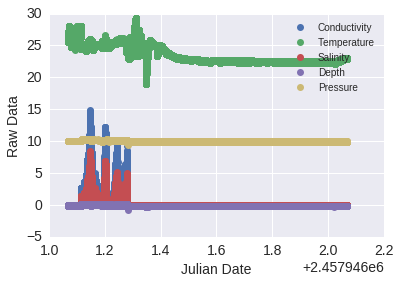

In [50]:
plt.plot(ctd['Julian_Date'], ctd['Conductivity'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Temperature'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Salinity'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Depth'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Pressure'], 'o')

plt.legend(['Conductivity', 'Temperature', 'Salinity', 'Depth', 'Pressure', 'Specific conductivity'])
plt.xlabel('Julian Date')
plt.ylabel('Raw Data')

Based on this, let's throw out all the data from Julian Date 1.6 onward.

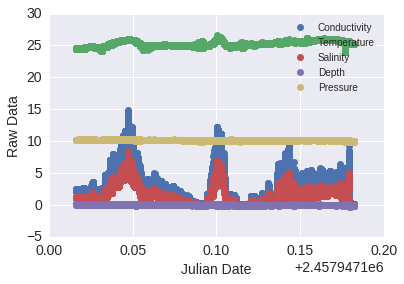

In [51]:
ctd = ctd.drop(ctd[ctd.Julian_Date > (1.282 + 2457946)].index)
ctd = ctd.drop(ctd[ctd.Julian_Date < (1.116 + 2457946)].index)

plt.plot(ctd['Julian_Date'], ctd['Conductivity'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Temperature'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Salinity'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Depth'], 'o')
plt.plot(ctd['Julian_Date'], ctd['Pressure'], 'o')

plt.legend(['Conductivity', 'Temperature', 'Salinity', 'Depth', 'Pressure', 'Specific conductivity'])
plt.xlabel('Julian Date')
plt.ylabel('Raw Data')

## GGA Cleaning
For this dataset, I will perform similar time cleaning so that all the sensors can be accurately mapped.

In [4]:
gga = sc.clean_gga(gga)
gga = gga.loc[:,['Time','Year','Month','Day','Hour','Minute','Second','Seconds_Elapsed','Julian_Date','CH4_ppm','CO2_ppm']]
gga.head(2)

,Time,Year,Month,Day,Hour,Minute,Second,Seconds_Elapsed,Julian_Date,CH4_ppm,CO2_ppm
0,07/12/2017 13:51:38.726,2017,7,12,13.0,51.0,38.726,1086698.726,2.457947e+06,1.90953,391.372
1,07/12/2017 13:51:39.703,2017,7,12,13.0,51.0,39.703,1086699.703,2.457947e+06,1.90693,391.286


There is an additional step here, in which the methane and CO2 needs to be adjusted based upon the dge equilibrator pressure.

For this, we look at the DGE data and see that the sweep gas pressure is around 2400 (or 240 millibars). 

In [40]:
def convert(gr, gas):
    if gas == "CH4":
        eff = 0.1511
        gppm = 1.834
    elif gas == "CO2":
        eff = 0.806
        gppm = 0.0
    peq = 236.7
    
    ui = peq*gppm/1000.
    ua = gr*peq/1000.
    
    return (ua - ui)/eff + ui

gga.loc[:,'CH4_ppm_adjusted'] = gga.apply(lambda x : convert(x['CH4_ppm'], 'CH4'), axis=1)
gga.loc[:,'CO2_ppm_adjusted'] = gga.apply(lambda x : convert(x['CO2_ppm'], 'CO2'), axis=1)

print convert(1.0, 'CO2')

0.293672456576


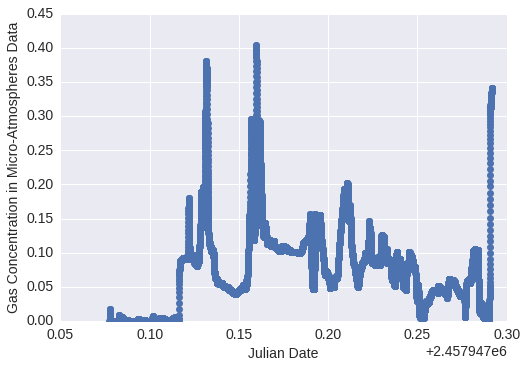

In [14]:
# plt.plot(gga['Julian_Date'], gga['CH4_ppm'], 'o')
plt.plot(gga['Julian_Date'], gga['CH4_ppm_adjusted'], 'o')
# plt.plot(gga['Julian_Date'], gga['CO2_ppm'], 'o')

# plt.legend(['CH4_ppm', 'CH4_ppm_adjusted'])
plt.xlabel('Julian Date')
plt.ylabel('Gas Concentration in Micro-Atmospheres Data')

## Combining GGA and CTD Data
Let's see what the union of these datasets looks like

In [174]:
ctd_gga = pd.merge(ctd, gga, how='left', left_on=['Hour', 'Minute'], right_on = ['Hour','Minute'])

ctd_gga.head(2)

,Time_x,Conductivity,Temperature,Pressure,Sea pressure,Depth,Salinity,Specific conductivity,Density anomaly,Speed of sound,Year_x,Month_x,Day_x,Hour,Minute,Second_x,Julian_Date_x,Seconds_Elapsed_x,Time_y,Year_y,Month_y,Day_y,Second_y,Seconds_Elapsed_y,Julian_Date_y,CH4_ppm,CO2_ppm,CH4_ppm_adjusted,CO2_ppm_adjusted
0,2017-07-12 13:48:00.000,0.001010,27.446920,10.021720,-0.110780,-0.109876,0.012674,0.965074,NaN,1503.033463,2017,7,12,13.0,48.0,0.000,2.457947e+06,1086480.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-07-12 13:48:00.167,0.000088,27.450818,10.024111,-0.108389,-0.107505,0.012937,0.084352,NaN,1503.043505,2017,7,12,13.0,48.0,0.167,2.457947e+06,1086480.167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


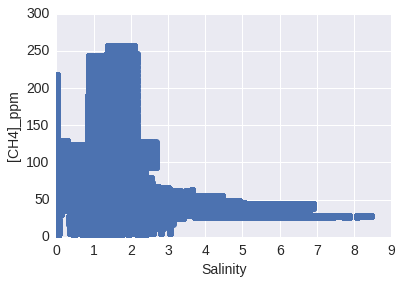

In [175]:
plt.plot(ctd_gga['Salinity'], ctd_gga['CH4_ppm'], 'o')

plt.xlabel('Salinity')
plt.ylabel('[CH4]_ppm')

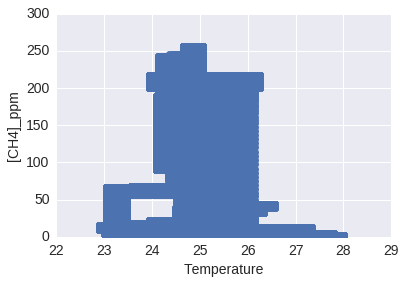

In [176]:
plt.plot(ctd_gga['Temperature'], ctd_gga['CH4_ppm'], 'o')

plt.xlabel('Temperature')
plt.ylabel('[CH4]_ppm')

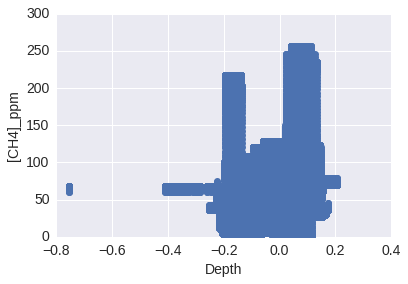

In [177]:
plt.plot(ctd_gga['Depth'], ctd_gga['CH4_ppm'], 'o')

plt.xlabel('Depth')
plt.ylabel('[CH4]_ppm')

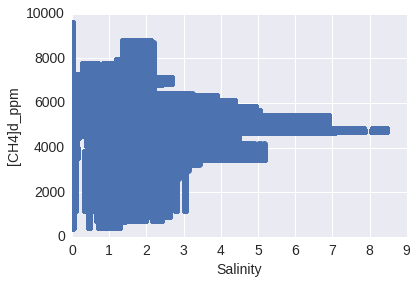

In [178]:
plt.plot(ctd_gga['Salinity'], ctd_gga['CO2_ppm'], 'o')

plt.xlabel('Salinity')
plt.ylabel('[CH4]d_ppm')

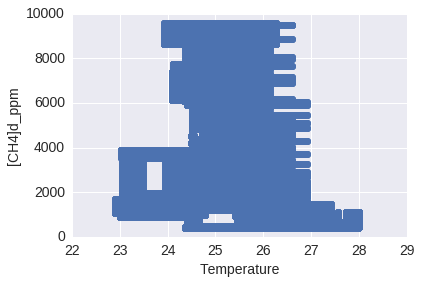

In [179]:
plt.plot(ctd_gga['Temperature'], ctd_gga['CO2_ppm'], 'o')

plt.xlabel('Temperature')
plt.ylabel('[CH4]d_ppm')

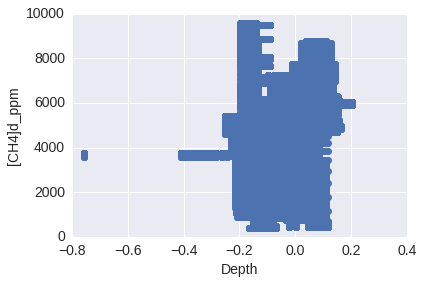

In [180]:
plt.plot(ctd_gga['Depth'], ctd_gga['CO2_ppm'], 'o')

plt.xlabel('Depth')
plt.ylabel('[CH4]d_ppm')

## Optode Cleaning

In [15]:
op = sc.clean_optode(op)
op.head(2)

,posixtime,model,SN,O2Concentration,AirSaturation,Temperature,CalPhase,TCPhase,C1RPh,C2RPh,C1Amp,C2Amp,RawTemp,Julian_Date
0,1.499870e+09,4831,277,189.8738,74.14807,25.39276,33.18269,33.18269,41.85463,8.671936,653.6945,718.0435,29.84055,2.457947e+06
1,1.499870e+09,4831,277,189.7653,74.11290,25.39804,33.18711,33.18711,41.86147,8.674355,653.6395,717.8172,29.66982,2.457947e+06


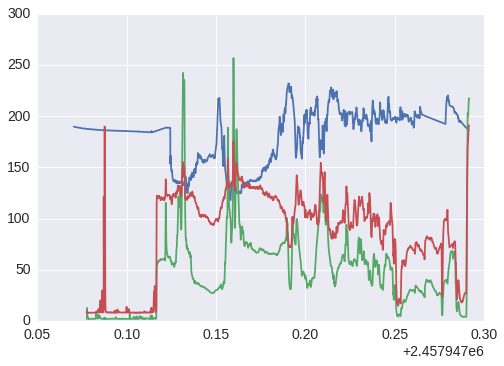

In [16]:
plt.plot(op['Julian_Date'], op['O2Concentration'])
plt.plot(gga['Julian_Date'], gga['CH4_ppm'])
plt.plot(gga['Julian_Date'], gga['CO2_ppm']/50)

## Cleaning AirMar Data

In [15]:
airmar = sc.clean_airmar(airmar)
airmar = airmar.loc[:,['lat',
                       'lon',
                       'Julian_Date',
                       'Year',
                       'Month',
                       'Day',
                       'Hour',
                       'Minute',
                       'Second',
                       'Seconds_Elapsed',
                       'COG_T',
                       'SOG_K',
                       'pressure_B',
                       'wind_dir_T',
                       'wind_speed_M',
                       'rateofturn']]
airmar.head(2)

/home/vpreston/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/vpreston/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,lat,lon,Julian_Date,Year,Month,Day,Hour,Minute,Second,Seconds_Elapsed,COG_T,SOG_K,pressure_B,wind_dir_T,wind_speed_M,rateofturn
77,4145.4890,7041.0444,2.457947e+06,2017,7,12,14.0,1.0,26.8,1087286.8,0.0,0.0,1.0178,124.1,0.4,0.0
78,4145.4888,7041.0433,2.457947e+06,2017,7,12,14.0,1.0,27.8,1087287.8,0.0,0.0,1.0171,110.6,0.4,0.0


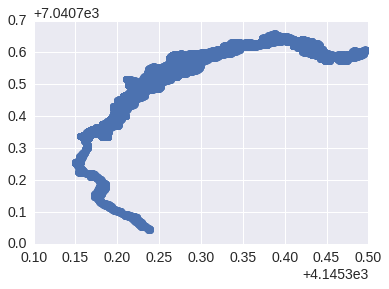

In [184]:
plt.plot(airmar['lat'], airmar['lon'], 'o')

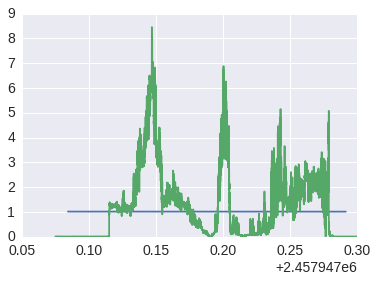

In [185]:
plt.plot(airmar['Julian_Date'], airmar['pressure_B'])
plt.plot(ctd['Julian_Date'], ctd['Salinity'])

## Cleaning DGEU

In [16]:
dge = sc.clean_dgeu(dge)

#strip away old data
dge = dge.drop(dge[dge.Julian_Date > (1.3 + 2457946)].index)
dge = dge.drop(dge[dge.Julian_Date < (1.075 + 2457946)].index)

dge = dge.loc[:,['Julian_Date','SweepGas_Press_Avg','Year','Month','Day','Hour','Minute','Second','Seconds_Elapsed']]

dge.head(5)

,Julian_Date,SweepGas_Press_Avg,Year,Month,Day,Hour,Minute,Second,Seconds_Elapsed
56473,2.457947e+06,4913,2017,7,12,14.0,0.0,30.0,1087230.0
56474,2.457947e+06,4916,2017,7,12,14.0,0.0,31.0,1087231.0
56475,2.457947e+06,4915,2017,7,12,14.0,0.0,32.0,1087232.0
56476,2.457947e+06,4914,2017,7,12,14.0,0.0,33.0,1087233.0
56477,2.457947e+06,4916,2017,7,12,14.0,0.0,34.0,1087234.0


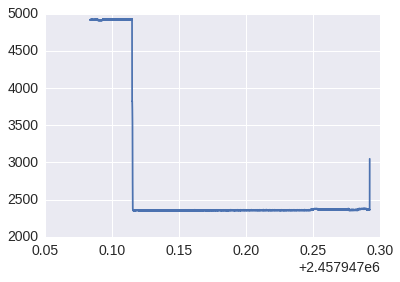

In [187]:
plt.plot(dge['Julian_Date'], dge['SweepGas_Press_Avg'])

## Cleaning Nitrate

In [40]:
nitrate = sc.clean_nitrate(nitrate)
nitrate = nitrate.loc[:,['Julian_Date','0.00','Year','Month','Day','Hour','Minute','Second','Seconds_Elapsed']]
nitrate.head(2)

,Julian_Date,0.00,Year,Month,Day,Hour,Minute,Second,Seconds_Elapsed
1,2.457946e+06,11.62,2017,7,11,20,22,2.4780,1.023722e+06
2,2.457946e+06,10.09,2017,7,11,20,22,4.7568,1.023725e+06


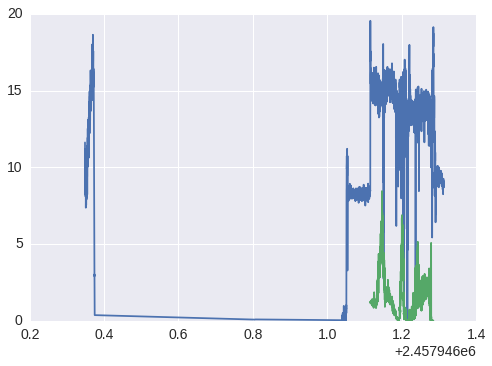

In [41]:
plt.plot(nitrate['Julian_Date'], nitrate['0.00'])
plt.plot(ctd['Julian_Date'], ctd['Salinity'])

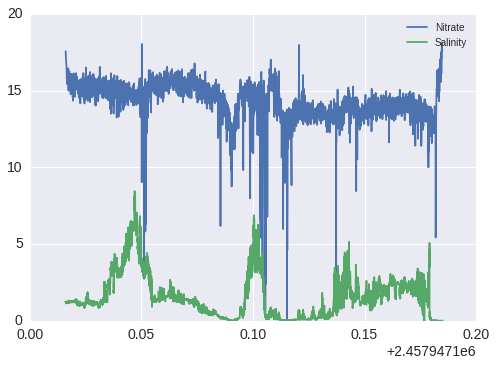

In [42]:
#strip away old data
nitrate = nitrate.drop(nitrate[nitrate.Julian_Date > (1.285 + 2457946)].index)
nitrate = nitrate.drop(nitrate[nitrate.Julian_Date < (1.116 + 2457946)].index)
nitrate = nitrate.drop(nitrate[nitrate['0.00'] < 0].index)

plt.plot(nitrate['Julian_Date'], nitrate['0.00'])
plt.plot(ctd['Julian_Date'], ctd['Salinity'])
plt.legend(['Nitrate', 'Salinity'])

## Combining CTD with AirMar


In [191]:
ctd_airmar = pd.merge(ctd, airmar, how='outer', left_on=['Hour', 'Minute'], right_on = ['Hour','Minute'])

ctd_airmar.head(2)

,Time,Conductivity,Temperature,Pressure,Sea pressure,Depth,Salinity,Specific conductivity,Density anomaly,Speed of sound,Year_x,Month_x,Day_x,Hour,Minute,Second_x,Julian_Date_x,Seconds_Elapsed_x,lat,lon,Julian_Date_y,Year_y,Month_y,Day_y,Second_y,Seconds_Elapsed_y,COG_T,SOG_K,pressure_B,wind_dir_T,wind_speed_M,rateofturn
0,2017-07-12 13:48:00.000,0.001010,27.446920,10.021720,-0.110780,-0.109876,0.012674,0.965074,NaN,1503.033463,2017,7,12,13.0,48.0,0.000,2.457947e+06,1086480.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-07-12 13:48:00.167,0.000088,27.450818,10.024111,-0.108389,-0.107505,0.012937,0.084352,NaN,1503.043505,2017,7,12,13.0,48.0,0.167,2.457947e+06,1086480.167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


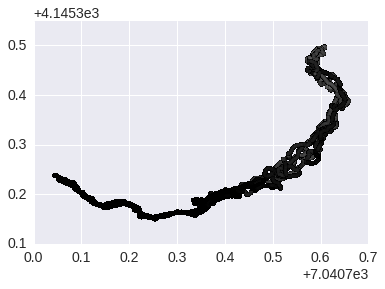

In [192]:
plt.scatter(ctd_airmar['lon'], ctd_airmar['lat'], c=ctd_airmar['Salinity'], s=10)
plt.gray()

## Combining GGA and AirMar

In [19]:
airmar_gga = pd.merge(airmar, gga, how='right', left_on=['Hour', 'Minute'], right_on = ['Hour','Minute'])
airmar_gga.head(2)

,lat,lon,Julian_Date_x,Year_x,Month_x,Day_x,Hour,Minute,Second_x,Seconds_Elapsed_x,COG_T,SOG_K,pressure_B,wind_dir_T,wind_speed_M,rateofturn,Time,Year_y,Month_y,Day_y,Second_y,Seconds_Elapsed_y,Julian_Date_y,CH4_ppm,CO2_ppm,CH4_ppm_adjusted,CO2_ppm_adjusted
0,4145.4890,7041.0444,2.457947e+06,2017.0,7.0,12.0,14.0,1.0,26.8,1087286.8,0.0,0.0,1.0178,124.1,0.4,0.0,07/12/2017 14:01:00.439,2017,7,12,0.439,1087260.439,2.457947e+06,4.58683,465.184,0.00436,0.138516
1,4145.4888,7041.0433,2.457947e+06,2017.0,7.0,12.0,14.0,1.0,27.8,1087287.8,0.0,0.0,1.0171,110.6,0.4,0.0,07/12/2017 14:01:00.439,2017,7,12,0.439,1087260.439,2.457947e+06,4.58683,465.184,0.00436,0.138516


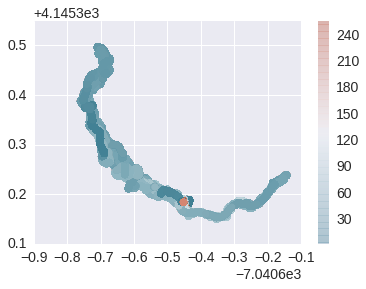

In [194]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-airmar_gga['lon'], airmar_gga['lat'], c=airmar_gga['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

## Pulling out Transects
Let's look at each transect seperately on a map. We'll make seperate dataframes for each transect to ease with that process.

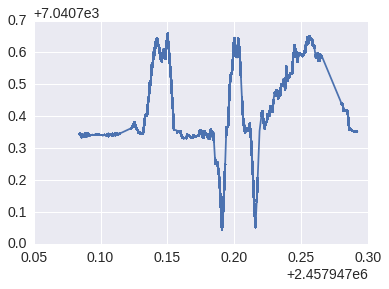

In [195]:
# a transect happens in time and space. So, as time goes forward (order by Julian Day)
# we want to truncate the dataframe at a certain place. In this case, around the 
# 4145.8 latitude and 7041.3 longitude for the rightmost point and 4145.55 latitude
# and 7040.75 longitude for the left/bottomost point.

# we can walk through the time sorted dataset and simply cut information at these
# points for now. We can also look at the time graph and just do it that way

plt.plot(airmar_gga['Julian_Date_x'], airmar_gga['lon'])

So, one transect to Julian_Date 2,457,947.14, one to 2,457,947.19, one to .21, one to .23, one to 0.26, one to the end. Let's create a column in the dataset for "transect" and label it A, B, C, D, E, F.

A - 0.14
B - 0.19
C - 0.21
D - 0.23
E - 0.26
F - 0.30

In [20]:
transect_A = airmar_gga[airmar_gga['Julian_Date_x'] <= 2457947.14]
transect_B = airmar_gga[(airmar_gga['Julian_Date_x'] <= 2457947.19) & (airmar_gga['Julian_Date_x'] > 2457947.14)]
transect_C = airmar_gga[(airmar_gga['Julian_Date_x'] <= 2457947.205) & (airmar_gga['Julian_Date_x'] > 2457947.18)]
transect_D = airmar_gga[(airmar_gga['Julian_Date_x'] <= 2457947.216) & (airmar_gga['Julian_Date_x'] > 2457947.205)]
transect_E = airmar_gga[(airmar_gga['Julian_Date_x'] <= 2457947.26) & (airmar_gga['Julian_Date_x'] > 2457947.216)]
transect_F = airmar_gga[airmar_gga['Julian_Date_x'] > 2457947.26]

In [21]:
transect_A.head(2)

,lat,lon,Julian_Date_x,Year_x,Month_x,Day_x,Hour,Minute,Second_x,Seconds_Elapsed_x,COG_T,SOG_K,pressure_B,wind_dir_T,wind_speed_M,rateofturn,Time,Year_y,Month_y,Day_y,Second_y,Seconds_Elapsed_y,Julian_Date_y,CH4_ppm,CO2_ppm,CH4_ppm_adjusted,CO2_ppm_adjusted
0,4145.4890,7041.0444,2.457947e+06,2017.0,7.0,12.0,14.0,1.0,26.8,1087286.8,0.0,0.0,1.0178,124.1,0.4,0.0,07/12/2017 14:01:00.439,2017,7,12,0.439,1087260.439,2.457947e+06,4.58683,465.184,0.00436,0.138516
1,4145.4888,7041.0433,2.457947e+06,2017.0,7.0,12.0,14.0,1.0,27.8,1087287.8,0.0,0.0,1.0171,110.6,0.4,0.0,07/12/2017 14:01:00.439,2017,7,12,0.439,1087260.439,2.457947e+06,4.58683,465.184,0.00436,0.138516


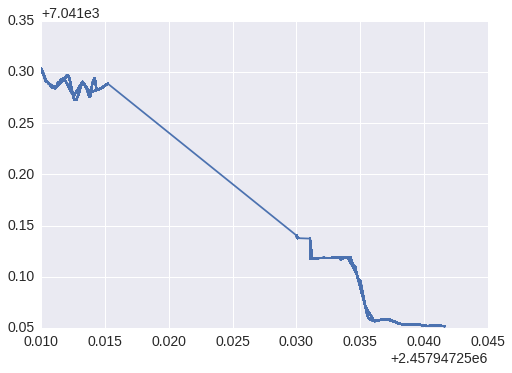

In [22]:
plt.plot(transect_F['Julian_Date_x'], transect_F['lon'])

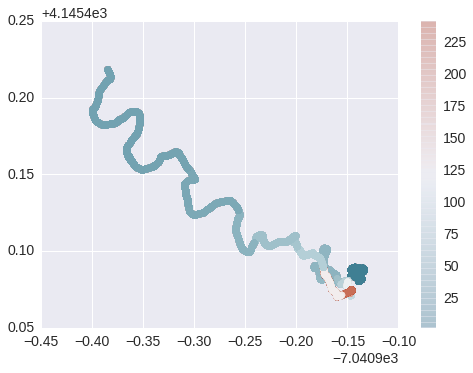

In [23]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_A['lon'], transect_A['lat'], c=transect_A['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

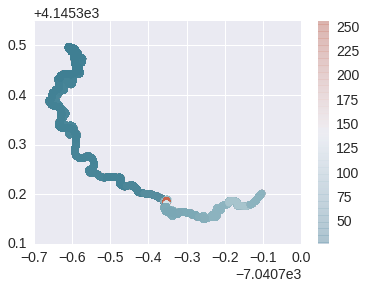

In [200]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_B['lon'], transect_B['lat'], c=transect_B['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

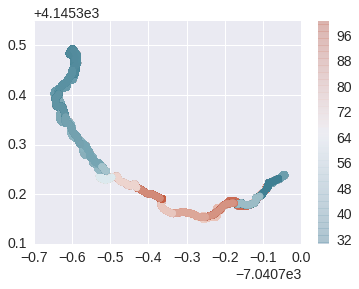

In [201]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_C['lon'], transect_C['lat'], c=transect_C['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

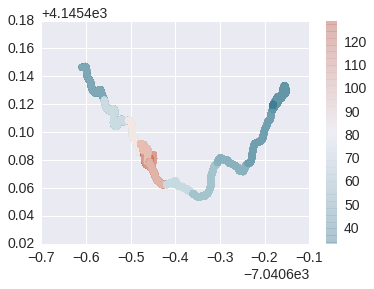

In [202]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_D['lon'], transect_D['lat'], c=transect_D['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

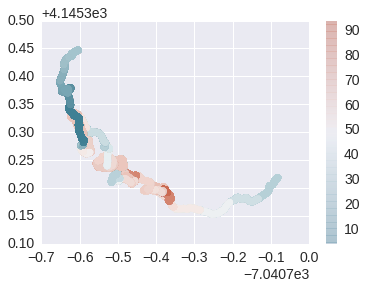

In [203]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_E['lon'], transect_E['lat'], c=transect_E['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

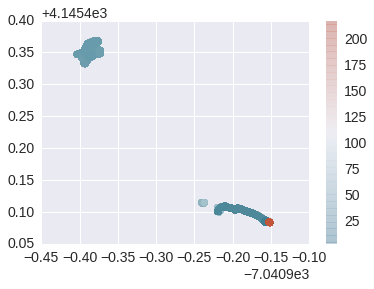

In [204]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_F['lon'], transect_F['lat'], c=transect_F['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

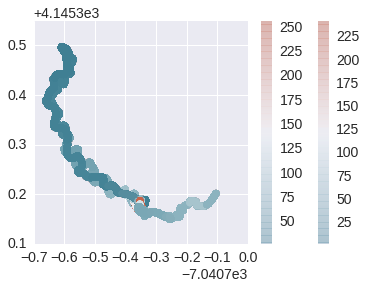

In [205]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(-transect_A['lon'], transect_A['lat'], c=transect_A['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points)

points2 = ax.scatter(-transect_B['lon'], transect_B['lat'], c=transect_B['CH4_ppm'],s=50, alpha=0.2, lw=0, cmap=cmap)
f.colorbar(points2)

## Visualizing Transects, Further Cleaning
Now that the basic thing is made, let's go ahead and clean up the joint dataframes by dropping unneseccary columns, interpolating data more succinctly, and determining the best method for visualizing the information on graphs.

In [206]:
from descartes import PolygonPatch
from shapely.geometry import LineString
import shapefile

In [207]:
def dms2dd(info):
    degrees = float(str(info)[0:2])
    minutes = float(str(info)[2:]) / 60.0
    dd = degrees + minutes;
#     print degrees, minutes, seconds
    return dd;

transect_A.loc[:, 'lon_mod'] = transect_A.apply(lambda x : dms2dd(x['lon']), axis=1)
transect_A.loc[:, 'lat_mod'] = transect_A.apply(lambda x : dms2dd(x['lat']), axis=1)


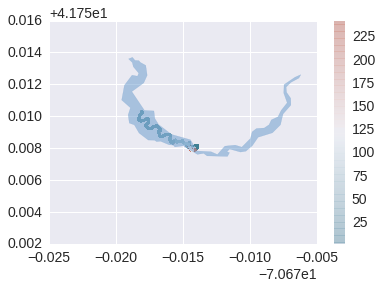

In [208]:
polys  = shapefile.Reader('./GIS_Data/River.shp')
# first polygon
poly = polys.iterShapes().next().__geo_interface__
# print poly


mapper = plt.figure()
ax = mapper.gca()
ax.add_patch(PolygonPatch(poly, fc="#6699cc", ec="#6699cc", alpha=0.5, zorder=2))
# plt.show()

cmap = sns.diverging_palette(220, 20, as_cmap=True)
points = ax.scatter(-transect_A['lon_mod'], transect_A['lat_mod'], c=transect_A['CH4_ppm'], s=5, alpha=0.2, lw=0, cmap=cmap)
mapper.colorbar(points)

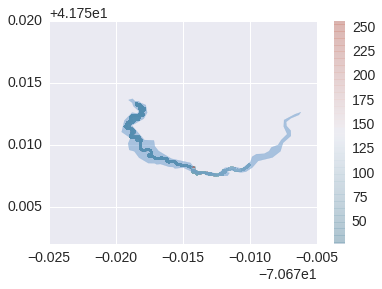

In [209]:
transect_B.loc[:, 'lon_mod'] = transect_B.apply(lambda x : dms2dd(x['lon']), axis=1)
transect_B.loc[:, 'lat_mod'] = transect_B.apply(lambda x : dms2dd(x['lat']), axis=1)

map_b = plt.figure()
ax = map_b.gca()
ax.add_patch(PolygonPatch(poly, fc="#6699cc", ec="#6699cc", alpha=0.5, zorder=2))
# plt.show()

cmap = sns.diverging_palette(220, 20, as_cmap=True)
points = ax.scatter(-transect_B['lon_mod'], transect_B['lat_mod'], c=transect_B['CH4_ppm'], s=5, alpha=0.2, lw=0, cmap=cmap)
map_b.colorbar(points)

(-70.691185, -70.675049, 41.756619, 41.765134)

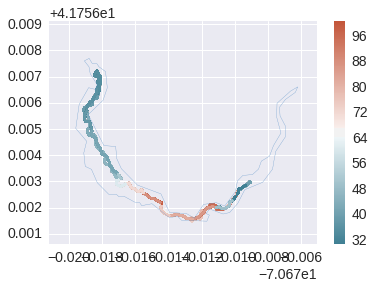

In [210]:
transect_C.loc[:, 'lon_mod'] = transect_C.apply(lambda x : dms2dd(x['lon']), axis=1)
transect_C.loc[:, 'lat_mod'] = transect_C.apply(lambda x : dms2dd(x['lat']), axis=1)

map_c = plt.figure()
ax = map_c.gca()

ax.add_patch(PolygonPatch(poly, fc="#6699cc", ec="#6699cc", alpha=1.0, fill=False, zorder=2))
# plt.show()

cmap = sns.diverging_palette(220, 20, as_cmap=True)
points = ax.scatter(-transect_C['lon_mod'], transect_C['lat_mod'], c=transect_C['CH4_ppm'], s=5, alpha=1.0, lw=0, cmap=cmap)
map_c.colorbar(points)

#westlimit=-70.691185; southlimit=41.756619; eastlimit=-70.675049; northlimit=41.765134
ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.675049, ymax=41.765134)

## Adding Data to Transects

Now, let's grab the nitrate and optode information and add them to each transect. Then we can make the suite of plots (property v property, spatial, temporal) for each transect seperately.

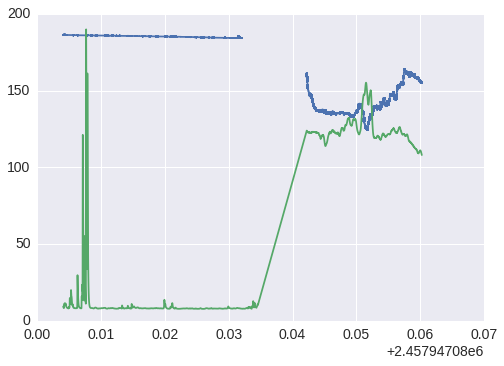

In [56]:
#take transect A first, add the nitrate and optode information
transect_A.loc[:,'JD'] = transect_A.apply(lambda x : round(x['Julian_Date_y'],4), axis=1)
op.loc[:,'JD'] = op.apply(lambda x : round(x['Julian_Date']-0.044,4), axis=1)

# transect_A_complete.head(2)
# op.head(2)
# op.loc[:,'Julian_Date'] = op.apply(lambda x: x['Julian_Date']-0.048, axis=1)
transect_A_complete = pd.merge(transect_A, op, how='outer', left_on=['JD'], right_on = ['JD'])
plt.plot(transect_A_complete['Julian_Date_y'],transect_A_complete['O2Concentration'])
plt.plot(transect_A_complete['Julian_Date_y'],transect_A_complete['CO2_ppm']/50)

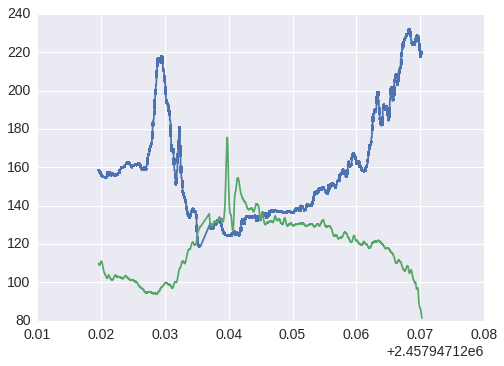

In [57]:
transect_B.loc[:,'JD'] = transect_B.apply(lambda x : round(x['Julian_Date_y'],4), axis=1)
op.loc[:,'JD'] = op.apply(lambda x : round(x['Julian_Date']-0.044,4), axis=1)

transect_B_complete = pd.merge(transect_B, op, how='outer', left_on=['JD'], right_on = ['JD'])
plt.plot(transect_B_complete['Julian_Date_y'],transect_B_complete['O2Concentration'])
plt.plot(transect_B_complete['Julian_Date_y'],transect_B_complete['CO2_ppm']/50)

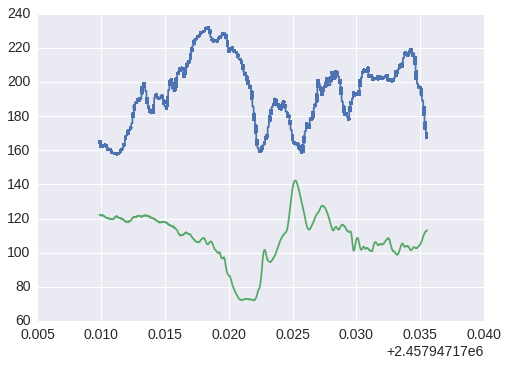

In [58]:
transect_C.loc[:,'JD'] = transect_C.apply(lambda x : round(x['Julian_Date_y'],4), axis=1)
op.loc[:,'JD'] = op.apply(lambda x : round(x['Julian_Date']-0.044,4), axis=1)

transect_C_complete = pd.merge(transect_C, op, how='outer', left_on=['JD'], right_on = ['JD'])
plt.plot(transect_C_complete['Julian_Date_y'],transect_C_complete['O2Concentration'])
plt.plot(transect_C_complete['Julian_Date_y'],transect_C_complete['CO2_ppm']/50)

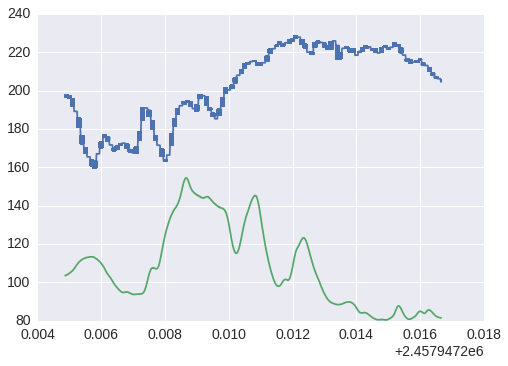

In [59]:
transect_D.loc[:,'JD'] = transect_D.apply(lambda x : round(x['Julian_Date_y'],4), axis=1)
op.loc[:,'JD'] = op.apply(lambda x : round(x['Julian_Date']-0.044,4), axis=1)

transect_D_complete = pd.merge(transect_D, op, how='outer', left_on=['JD'], right_on = ['JD'])
plt.plot(transect_D_complete['Julian_Date_y'],transect_D_complete['O2Concentration'])
plt.plot(transect_D_complete['Julian_Date_y'],transect_D_complete['CO2_ppm']/50)

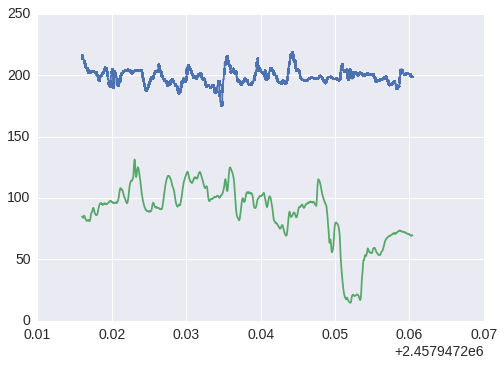

In [60]:
transect_E.loc[:,'JD'] = transect_E.apply(lambda x : round(x['Julian_Date_y'],4), axis=1)
op.loc[:,'JD'] = op.apply(lambda x : round(x['Julian_Date']-0.044,4), axis=1)

transect_E_complete = pd.merge(transect_E, op, how='outer', left_on=['JD'], right_on = ['JD'])
plt.plot(transect_E_complete['Julian_Date_y'],transect_E_complete['O2Concentration'])
plt.plot(transect_E_complete['Julian_Date_y'],transect_E_complete['CO2_ppm']/50)

(-70.691185, -70.675049, 41.756619, 41.765134)

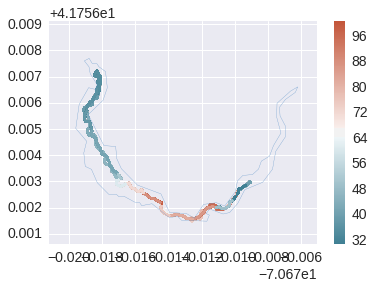

In [216]:
map_c = plt.figure()
ax = map_c.gca()

ax.add_patch(PolygonPatch(poly, fc="#6699cc", ec="#6699cc", alpha=1.0, fill=False, zorder=2))
# plt.show()

cmap = sns.diverging_palette(220, 20, as_cmap=True)
points = ax.scatter(-transect_C_complete['lon_mod'], transect_C_complete['lat_mod'], c=transect_C_complete['CH4_ppm'], s=5, alpha=1.0, lw=0, cmap=cmap)
map_c.colorbar(points)

#westlimit=-70.691185; southlimit=41.756619; eastlimit=-70.675049; northlimit=41.765134
ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.675049, ymax=41.765134)

(-70.691185, -70.675049, 41.756619, 41.765134)

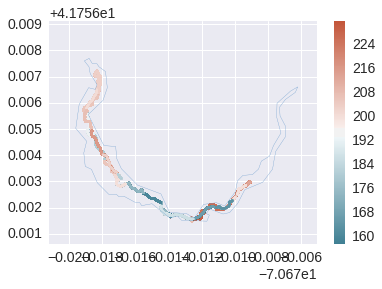

In [239]:
map_c = plt.figure()
ax = map_c.gca()

ax.add_patch(PolygonPatch(poly, fc="#6699cc", ec="#6699cc", alpha=1.0, fill=False, zorder=2))
# plt.show()

cmap = sns.diverging_palette(220, 20, as_cmap=True)
points = ax.scatter(-transect_C_complete['lon_mod'], transect_C_complete['lat_mod'], c=transect_C_complete['O2Concentration'], s=5, alpha=1.0, lw=0, cmap=cmap)
map_c.colorbar(points)

#westlimit=-70.691185; southlimit=41.756619; eastlimit=-70.675049; northlimit=41.765134
ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.675049, ymax=41.765134)

## Combining with Sample Interpolation
Now, let's start nearly from scratch with assembly, but pick a sensor stamp from which to inerpolate all other date. Let's choose the CTD for the baseline, and go from there.

In [240]:
#CTD and GGA
ctd = ctd.set_index('Julian_Date')
gga = gga.set_index('Julian_Date')

first = pd.concat([ctd, gga], axis=1, keys=['ctd', 'gga'])
first.head(2)

ctd                                      \
                                 Time Conductivity Temperature   Pressure   
Julian_Date                                                                 
2.457947e+06  2017-07-12 13:48:00.000     0.001010   27.446920  10.021720   
2.457947e+06  2017-07-12 13:48:00.167     0.000088   27.450818  10.024111   

                                                                     \
             Sea pressure     Depth  Salinity Specific conductivity   
Julian_Date                                                           
2.457947e+06    -0.110780 -0.109876  0.012674              0.965074   
2.457947e+06    -0.108389 -0.107505  0.012937              0.084352   

                                                                              \
             Density anomaly Speed of sound    Year Month   Day  Hour Minute   
Julian_Date                                                                    
2.457947e+06             NaN    1503.033463  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.043505  2017.0   7.0  12.0  13.0   48.0   

                                     gga                                    \
             Second Seconds_Elapsed Time Year Month Day Hour Minute Second   
Julian_Date                                                                  
2.457947e+06  0.000     1086480.000  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  0.167     1086480.167  NaN  NaN   NaN NaN  NaN    NaN    NaN   

                                                                                
             Seconds_Elapsed CH4_ppm CO2_ppm CH4_ppm_adjusted CO2_ppm_adjusted  
Julian_Date                                                                     
2.457947e+06             NaN     NaN     NaN              NaN              NaN  
2.457947e+06             NaN     NaN     NaN              NaN              NaN

In [241]:
df = first.interpolate()
df.head(10)

ctd                                      \
                                 Time Conductivity Temperature   Pressure   
Julian_Date                                                                 
2.457947e+06  2017-07-12 13:48:00.000     0.001010   27.446920  10.021720   
2.457947e+06  2017-07-12 13:48:00.167     0.000088   27.450818  10.024111   
2.457947e+06  2017-07-12 13:48:00.333     0.001062   27.454051  10.019426   
2.457947e+06  2017-07-12 13:48:00.500     0.001251   27.456736  10.031129   
2.457947e+06  2017-07-12 13:48:00.667     0.000961   27.459952  10.034916   
2.457947e+06  2017-07-12 13:48:00.833     0.000231   27.463749  10.031216   
2.457947e+06  2017-07-12 13:48:01.000     0.000170   27.468032  10.033922   
2.457947e+06  2017-07-12 13:48:01.167     0.001295   27.472851  10.022673   
2.457947e+06  2017-07-12 13:48:01.333     0.000411   27.477603  10.019811   
2.457947e+06  2017-07-12 13:48:01.500     0.001230   27.482248  10.017923   

                                                                     \
             Sea pressure     Depth  Salinity Specific conductivity   
Julian_Date                                                           
2.457947e+06    -0.110780 -0.109876  0.012674              0.965074   
2.457947e+06    -0.108389 -0.107505  0.012937              0.084352   
2.457947e+06    -0.113074 -0.112152  0.012675              1.014279   
2.457947e+06    -0.101371 -0.100544  0.012678              1.194973   
2.457947e+06    -0.097584 -0.096789  0.012680              0.918198   
2.457947e+06    -0.101284 -0.100458  0.012829              0.220565   
2.457947e+06    -0.098578 -0.097774  0.012869              0.162399   
2.457947e+06    -0.109827 -0.108931  0.012684              1.236985   
2.457947e+06    -0.112689 -0.111770  0.012762              0.392545   
2.457947e+06    -0.114577 -0.113643  0.012686              1.174685   

                                                                              \
             Density anomaly Speed of sound    Year Month   Day  Hour Minute   
Julian_Date                                                                    
2.457947e+06             NaN    1503.033463  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.043505  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.051184  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.058072  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.066145  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.075703  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.086454  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.098052  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.109914  2017.0   7.0  12.0  13.0   48.0   
2.457947e+06             NaN    1503.121355  2017.0   7.0  12.0  13.0   48.0   

                                     gga                                    \
             Second Seconds_Elapsed Time Year Month Day Hour Minute Second   
Julian_Date                                                                  
2.457947e+06  0.000     1086480.000  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  0.167     1086480.167  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  0.333     1086480.333  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  0.500     1086480.500  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  0.667     1086480.667  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  0.833     1086480.833  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  1.000     1086481.000  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  1.167     1086481.167  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  1.333     1086481.333  NaN  NaN   NaN NaN  NaN    NaN    NaN   
2.457947e+06  1.500     1086481.500  NaN  NaN   NaN NaN  NaN    NaN    NaN   

                                                    

In [242]:
ctd_ind = ctd.index
df = df.loc[ctd_ind]

In [243]:
print len(ctd)
print len(gga)
print len(first)
print len(df)

116641
18939
135473
116641


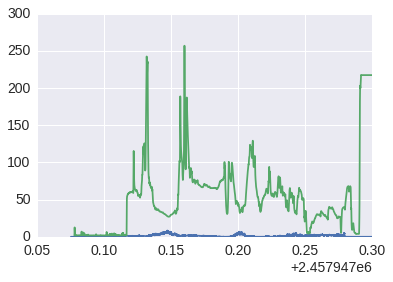

In [244]:
plt.plot(df['ctd']['Salinity'])
plt.plot(df['gga']['CH4_ppm'])

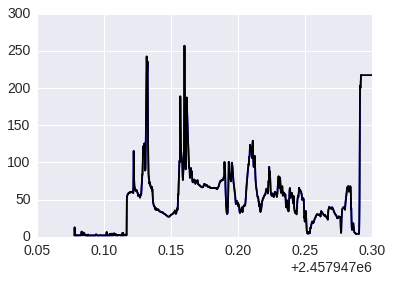

In [245]:
plt.plot(gga['CH4_ppm'], 'b')
plt.plot(df['gga']['CH4_ppm'],'k')

In [246]:
print first['gga']['CH4_ppm'].isnull().sum()
print df['gga']['CH4_ppm'].isnull().sum()

116534
1313


## Conclusions from Raw Data Processing
Now that we're walked through some basic data interpretations, handling data, and figures, this notebook has served its purpose. We will now create notebooks to do all cleaning in one place, and write new data CSVs for later interpretation. 

Essentially the steps will be:
- clean all data sets and add at least one common time stamp for all of them (Julian Date, Posixtime, Seconds Elapsed, etc)
- combine data on the common time stamp either through brute force merging, or through interpolation
- once data is combines, check information for reasonable values, saturation, etc
- create syntheszed or adjusted columns of data
- plot information

Functions and other elements created in this notebook will be pulled into future work through a static script loaded into future notebooks.